# Fig. 4. Decomposition results: patterns $\mathbf{W}$ and activation $\mathbf{H}$

In [1]:
import os
import glob
from collections import defaultdict
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import numpy.linalg as LA
import dill
import ssnmf

In [2]:
MVBS_PCP_path = '../ooi_sonar/zplsc_data_2015fall/nc_PCP/'
MVBS_rpca_file = '20150817-20151017_MVBS_time_Sv_rangeBin5_all_corrected_rpca.nc'

In [3]:
MVBS_rpca = xr.open_dataset(os.path.join(MVBS_PCP_path, MVBS_rpca_file))
low_rank = MVBS_rpca['low_rank']
n_observations, n_frequencies, n_depth_levels, n_pings = low_rank.shape

In [4]:
low_rank = low_rank.values.reshape([n_observations,-1])
low_rank.shape

(62, 15984)

In [5]:
low_rank_nonneg = low_rank - low_rank.min()

## Load pre-calculated ssNMF runs

In [6]:
rank_all = np.arange(2,10)

In [7]:
ssNMF_path = '../ooi_sonar/nmf_paper_analysis_files/hpc_results/smoothness_sweep/sm5e5_sp0/'
fname = sorted(glob.glob(os.path.join(ssNMF_path, '*.pkl')))

In [8]:
# Compute reconstruction error
mse_ori = []
smc_ori = []
for ff in fname:
    with open(ff,'rb') as openfile:
        x = dill.load(openfile)
    mse = []
    smc = []
    for mm in x:
        mse.append(np.linalg.norm(low_rank_nonneg.T - mm.W@mm.H)**2)
        smc.append(np.linalg.norm(mm.H[:,1:] - mm.H[:,:-1])**2)
    mse_ori += mse
    smc_ori += smc

In [9]:
mse_ori = np.array(mse_ori).reshape((len(rank_all),-1))
smc_ori = np.array(smc_ori).reshape((len(rank_all),-1))

## Select only ssNMF runs with small reconstruction errors

### Roughly separate good and bad runs using k-means clustering

In [10]:
from sklearn.cluster import KMeans

We know that the ssNMF results often fall into 2 major clusters on the smoothness cost (`smc`) vs reconstruction error (`mse`) plot. Here we use a simple clustering to select only the cluster with smaller `smc` and `mse` values.

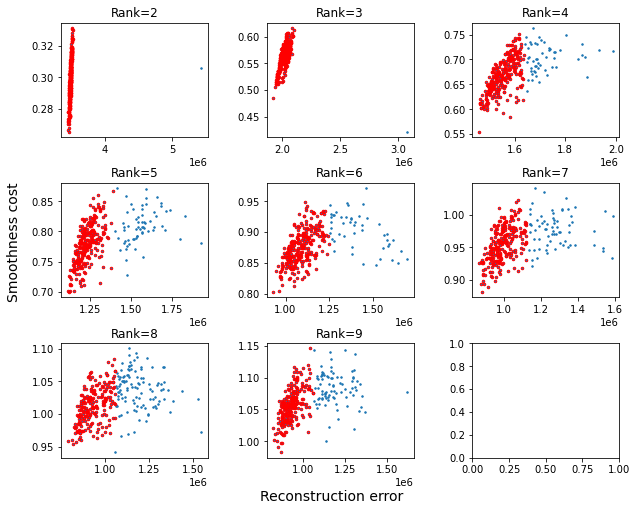

In [11]:
runs_wanted = []
fig, ax = plt.subplots(3,3,figsize=(10,8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for seq,rr in enumerate(rank_all):
    samples = np.vstack((mse_ori[seq,:], smc_ori[seq,:])).T
    kmeans = KMeans(n_clusters=2, random_state=0).fit(samples)
    which_is_good = kmeans.cluster_centers_[:,0].argmin(axis=0)
    runs_wanted.append(kmeans.labels_==which_is_good)
    axseq = np.unravel_index(seq,(3,3))
    ax[axseq].plot(samples[:,0], samples[:,1], '.', markersize=3)
    ax[axseq].plot(samples[kmeans.labels_==which_is_good, 0], 
                   samples[kmeans.labels_==which_is_good, 1], 
                   'r.', markerfacecolor='none', markersize=5)
    ax[axseq].set_title('Rank=%d'%rr)
fig.text(0.5, 0.05, 'Reconstruction error', fontsize=14, ha='center')
fig.text(0.05, 0.5, 'Smoothness cost', fontsize=14, va='center', rotation='vertical')
plt.show()

We can see that k-means clustering can separate out of the "bad" runs (those with large reconstruction error) but in some cases would force a cluster boundary in the middle of the data, like in the cases for rank=4, 7, 8, 9.

### Clean up runs

`runs_wanted` is a list of boolean arrays for each rank, with entries `True` meaning this is a good run and `False` otherwise.

In [12]:
np.array(runs_wanted).shape

(8, 320)

In [13]:
runs_wanted_all = np.array(runs_wanted).reshape(-1).reshape(-1,40)

In [14]:
runs_wanted_all.shape  # these are now in the order of param files

(64, 40)

In [15]:
runs_wanted_all = [np.nonzero(runs_wanted_all[x,:])[0] for x in range(runs_wanted_all.shape[0])]

In [16]:
runs_wanted_all  # these correspond to the line numbers of the good runs within each param file

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16

In [17]:
len(runs_wanted_all)  # there are a total of 64 .pkl files

64

## Compile Hs and Ws and MSE from good runs

In [18]:
mse_ori.shape

(8, 320)

In [19]:
# Get MSE from the good runs
ssNMF_results = defaultdict(list)
for rr in range(len(rank_all)):
    ssNMF_results['MSE'].append(mse_ori[rr,runs_wanted[rr]])

In [20]:
# Get H and W from the good runs
for seq_file,ff in enumerate(fname):
    with open(ff,'rb') as openfile:
        x = dill.load(openfile)
    
    # Start fresh H and W lists for new rank
    if seq_file % 8 == 0:  # each rank has 8 files, so seq_f%8=0 means the beginning of a rank
        print('file %0d: '%seq_file +'starting new rank')
        H, W, fn_ln = [], [], []
    
    # Collect H from good runs in file ff
    print('gather H and W in file: %s'%os.path.basename(ff))
    for seq_line,mm in enumerate(x):  # loop through all results in this file
        if seq_line in runs_wanted_all[seq_file]:
            H.append(mm.H)
            W.append(mm.W)
            fn_ln.append([seq_file, seq_line])
    print('   total %d Hs and Ws gathered' % len(H))

    # Save H and W lists for this rank to master dict
    if (seq_file+1) % 8 == 0:
        ssNMF_results['H'].append(H)
        ssNMF_results['W'].append(W)
        ssNMF_results['filenum_linenum'].append(fn_ln)
        print('file %0d: '%seq_file +'ending this rank')
        print('---------------------------------------')

file 0: starting new rank
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch01.pkl
   total 40 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch02.pkl
   total 80 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch03.pkl
   total 120 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch04.pkl
   total 159 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch05.pkl
   total 199 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch06.pkl
   total 239 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch07.pkl
   total 279 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch08.pkl
   total 319 Hs and Ws gathered
file 7: ending this rank
---------------------------------------
file 8: starting new rank
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch09.pkl
   total 40 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch10.pkl
   total 80 Hs and Ws gathered
gather 

### Keep track of the original line number in the parameter file

`ssNMF_results['filenum_linenum']` contains the filenum and linenum matching information to figure out the random seed used for a specific run. Let's calculate that below.

In [21]:
# Sanity check that the number of entries in filenum_linenum is the same as MSE
len(ssNMF_results['filenum_linenum'][2]) == len(ssNMF_results['MSE'][2])

True

In [22]:
# Find original line number in param file
num_files_per_rank = 8
num_lines_per_file = 40

for seq, fn_ln in enumerate(ssNMF_results['filenum_linenum']):  # loop through all rank
    fn_ln = np.array(fn_ln)  # convert to np.array
    ln = (fn_ln[:,0] - seq*num_files_per_rank)*num_lines_per_file + fn_ln[:,1]
    ssNMF_results['filenum_linenum_original'].append(ln)

### Normalize H and W in different ways

In [23]:
for H_rank,W_rank in zip(ssNMF_results['H'], ssNMF_results['W']):
    H_divH, H_multW, W_divW = [], [], []
    for H,W in zip(H_rank, W_rank):
        H_divH.append((H.T/LA.norm(H, axis=1)).T)
        H_multW.append((H.T*LA.norm(W, axis=0)).T)
        W_divW.append(W/LA.norm(W, axis=0))
    ssNMF_results['H_divH'].append(H_divH)
    ssNMF_results['H_multW'].append(H_multW)
    ssNMF_results['W_divW'].append(W_divW)

## Load pre-calculated NMF results with NNDSVD initialization

In [24]:
with open('../ooi_sonar/nmf_paper_analysis_files/coph_corr_repeated_runs/NMF_NNDSVD_init.pickle', 'rb') as file:
    NMF_NNDSVD = dill.load(file)

In [25]:
NMF_NNDSVD['H'] = NMF_NNDSVD.pop('Hs')
NMF_NNDSVD['W'] = NMF_NNDSVD.pop('Ws')

In [26]:
for rr in rank_all:
    NMF_NNDSVD['W_normFac'][rr] = np.linalg.norm(NMF_NNDSVD['W'][rr],axis=1)
    NMF_NNDSVD['W_divW'][rr] = NMF_NNDSVD['W'][rr]/np.expand_dims(NMF_NNDSVD['W_normFac'][rr],axis=1)
    NMF_NNDSVD['H_multW'][rr] = NMF_NNDSVD['H'][rr]*np.expand_dims(NMF_NNDSVD['W_normFac'][rr],axis=0)
    NMF_NNDSVD['H_divH'][rr] = NMF_NNDSVD['H'][rr]/np.expand_dims(np.linalg.norm(NMF_NNDSVD['H'][rr],axis=0),axis=0)

## Component matching functions

In [27]:
def match_factors_by_W(Ws,NMF_Ws=None):
    """Ordering the components based on W components.
    """
    sample_num, _, rank_num = Ws.shape
    new_idx = np.zeros((sample_num, rank_num))
    if NMF_Ws is not None:
        Ws_ref = NMF_Ws.T
    else:
        Ws_ref = Ws[0,:,:]
    for k in range(sample_num):  # loop through all runs
        rho = np.corrcoef(Ws_ref.T, Ws[k,:,:].T)[:rank_num,rank_num:]
        index = [0 for r in range(rank_num)]
        for p in range(rank_num):
            index_max = np.argmax(rho)
            # index = np.argsort(rho, axis=1)
            i,j = np.unravel_index(index_max,(rank_num,rank_num))
            rho[:,j] = -2
            rho[i,:] = -2
            index[i] = j
        new_idx[k,:] = index
    return new_idx.astype(int)

In [28]:
def match_factors_by_H(Hs,NMF_Hs=None):
    """Ordering the components based on H curves.
    """
    sample_num, rank_num, _ = Hs.shape
    new_idx = np.zeros((sample_num, rank_num))
    if NMF_Hs is not None:
        Hs_ref = NMF_Hs
    else:
        Hs_ref = Hs[0,:,:].T
    for k in range(sample_num):  # loop through all runs
        rho = np.corrcoef(Hs_ref.T, Hs[k,:,:])[:rank_num,rank_num:]
        index = [0 for r in range(rank_num)]
        for p in range(rank_num):
            index_max = np.argmax(rho)
            # index = np.argsort(rho, axis=1)
            i,j = np.unravel_index(index_max,(rank_num,rank_num))
            rho[:,j] = -2
            rho[i,:] = -2
            index[i] = j
        new_idx[k,:] = index
    return new_idx.astype(int)

## Matching components based on classic NMF

In [29]:
def plot_match_by_H_NMF(ssNMF_results, rank_to_check):
    r_idx = np.nonzero(rank_to_check==rank_all)[0][0]
    fig,ax = plt.subplots(rank_to_check,2,figsize=(8,2.5*rank_to_check))#,sharey=True)
    for seq in range(rank_to_check):
        ax[seq,0].plot(NMF_NNDSVD['H'][rank_to_check][:,seq], 'C%d'%seq)
        Hs = np.array(ssNMF_results['H'][r_idx])
        new_idx = match_idx_by_H_NMF[r_idx]
        [ax[seq,1].plot(Hs[x,new_idx[x,seq],:], 'C%d'%seq, alpha=0.05) 
         for x in range(new_idx.shape[0])]
        if seq==0:
            ax[seq,0].set_title('Matched by H')
    plt.show()

In [30]:
match_idx_by_H_NMF = []
for r_idx in range(len(rank_all)):
    match_idx_by_H_NMF.append(match_factors_by_H(np.array(ssNMF_results['H'][r_idx]), 
                                                 NMF_Hs=NMF_NNDSVD['H'][rank_all[r_idx]]))

Rank=2 ========================== 


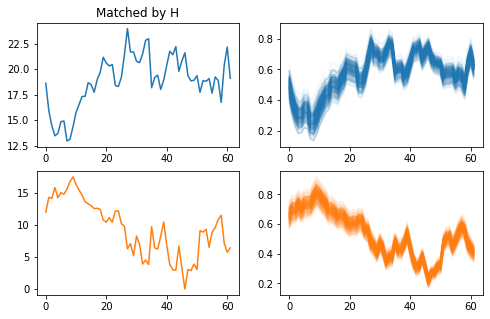

Rank=3 ========================== 


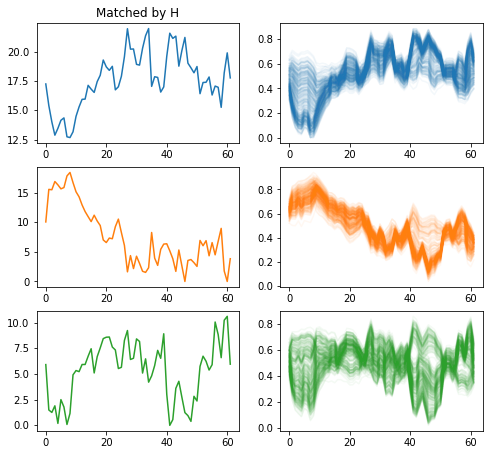

Rank=4 ========================== 


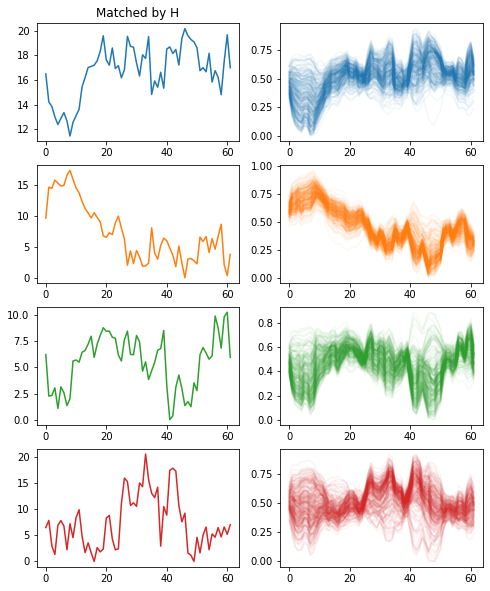

Rank=5 ========================== 


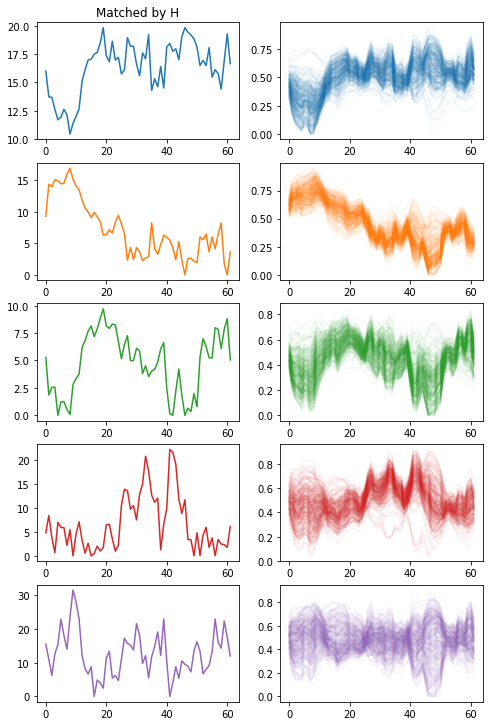

Rank=6 ========================== 


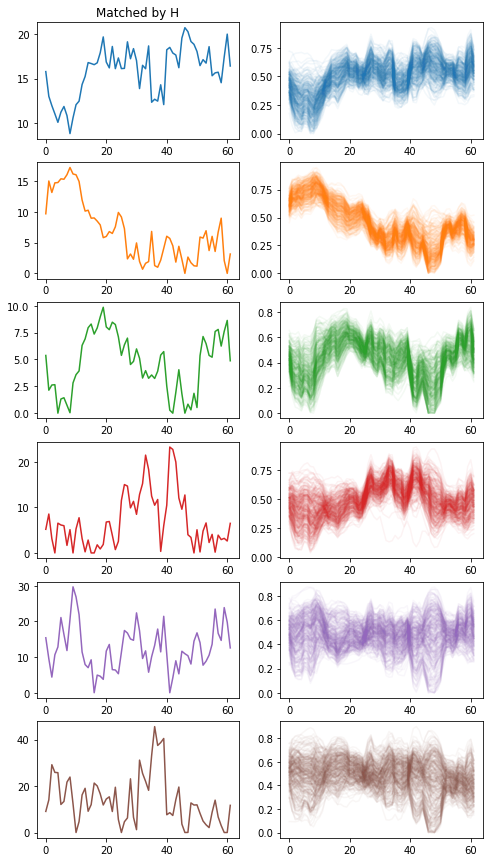

Rank=7 ========================== 


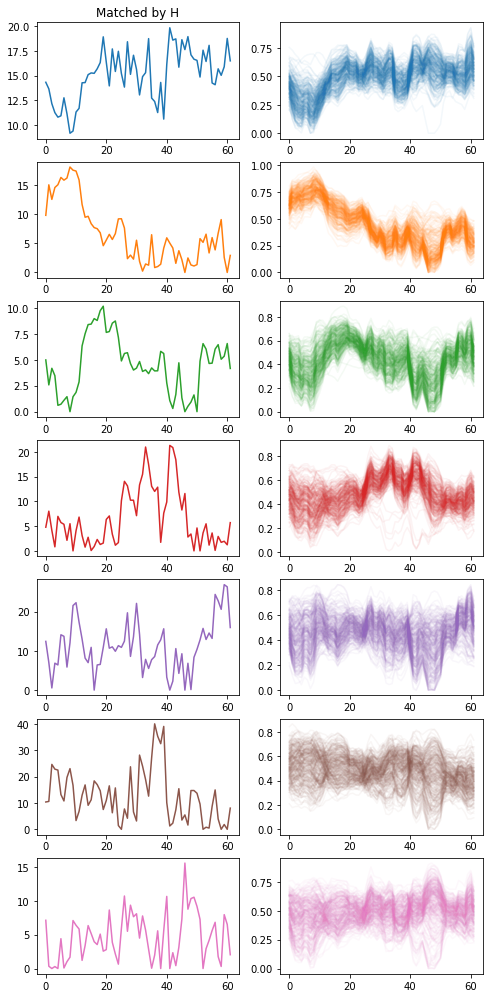

Rank=8 ========================== 


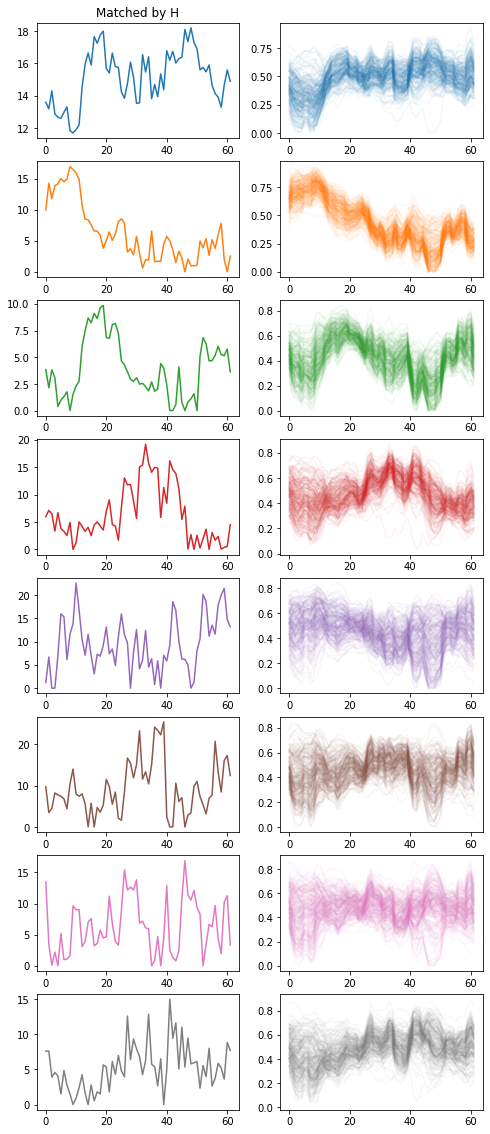

Rank=9 ========================== 


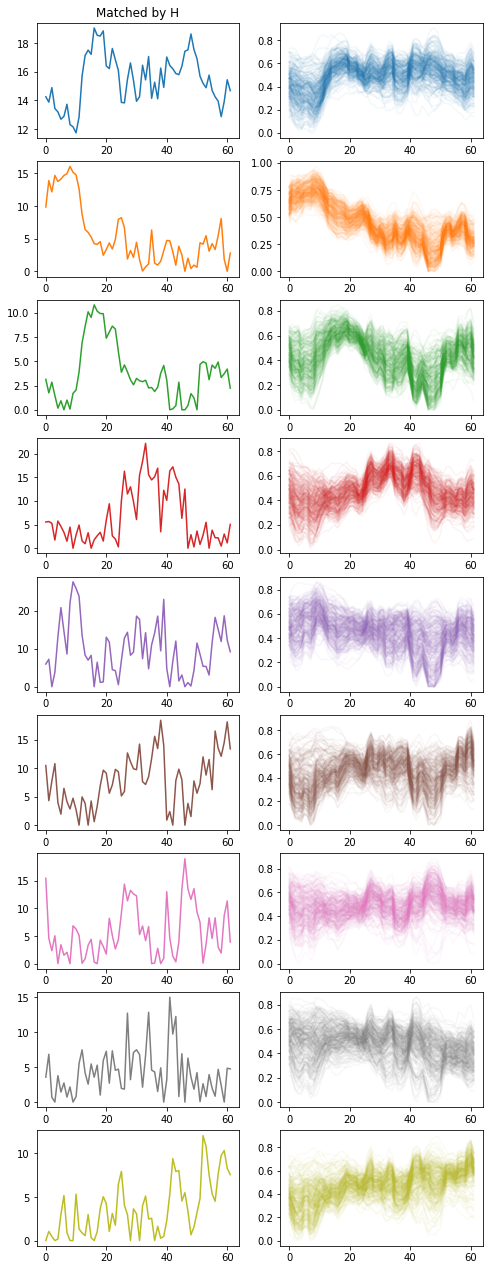

In [31]:
for rr in rank_all:
    print('Rank=%d ========================== '%rr)
    plot_match_by_H_NMF(ssNMF_results, rr)

## Rank=3 results

### Representative results

In [32]:
rank_to_check = 3
r_idx = np.nonzero(rank_to_check==rank_all)[0][0]
run_idx_sorted = np.argsort(ssNMF_results['MSE'][r_idx])

In [33]:
r_idx

1

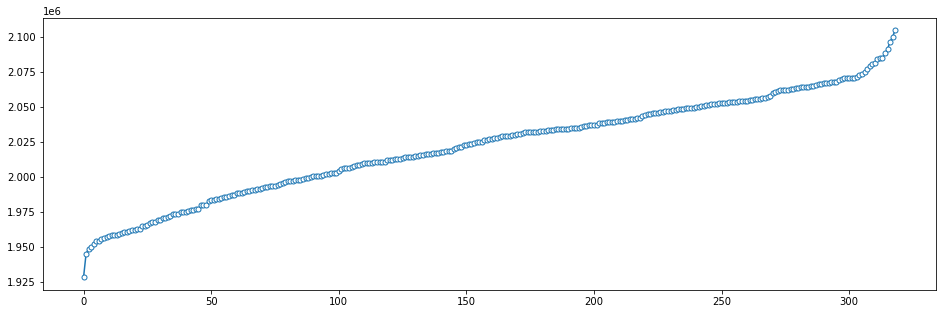

In [34]:
# Sanity check to make sure the MSE is sorted
plt.figure(figsize=(16,5))
plt.plot(ssNMF_results['MSE'][r_idx][run_idx_sorted], '.-', markersize=10, markerfacecolor='w')
plt.show()

We know the lowest cost run for rank=3 is actually an outlier significantly below the majority of runs ([fig above](#Roughly-separate-good-and-bad-runs-using-k-means-clustering)), so here we select the lowest of the main cluster.

In [35]:
# Select run_idx_sorted[1] instead of run_idx_sorted[0]
run_idx_sel = run_idx_sorted[1]

In [36]:
# component number sequence matching index
new_comp_seq_idx = match_idx_by_H_NMF[r_idx][run_idx_sel, :]  # instead of run_idx_sorted[0]

In [37]:
# sort and reshape Hs and Ws for display
H_type = 'H_multW'
W_type = 'W_divW'
Ws_reshaped = np.array(ssNMF_results[W_type][r_idx])[run_idx_sel, :, new_comp_seq_idx].\
                reshape(rank_to_check, n_frequencies*n_depth_levels, n_pings)
Hs_reshaped = np.array(ssNMF_results[H_type][r_idx])[run_idx_sel, new_comp_seq_idx, :].T

### Which random seed?

In [38]:
run_idx_sel  # run index selected

119

In [39]:
ssNMF_results['filenum_linenum_original'][r_idx][run_idx_sel]  # run index selected

119

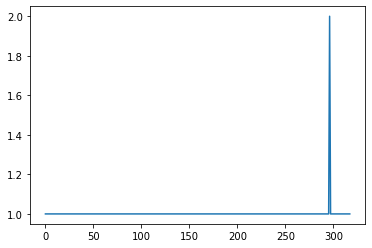

In [40]:
plt.plot(np.diff(ssNMF_results['filenum_linenum_original'][r_idx]))  # check that we only exclude 1 run

In [41]:
# Double check we can recover that exact run
file_num_sel, line_num_sel = ssNMF_results['filenum_linenum'][r_idx][run_idx_sel]

In [42]:
fname[file_num_sel]

'../ooi_sonar/nmf_paper_analysis_files/hpc_results/smoothness_sweep/sm5e5_sp0/ssNMF_sm5e+05_sp0.0_batch11.pkl'

In [43]:
with open(fname[file_num_sel],'rb') as openfile:
    x = dill.load(openfile)

In [44]:
x[line_num_sel]

In [45]:
W_recover = x[line_num_sel].W
H_recover = x[line_num_sel].H

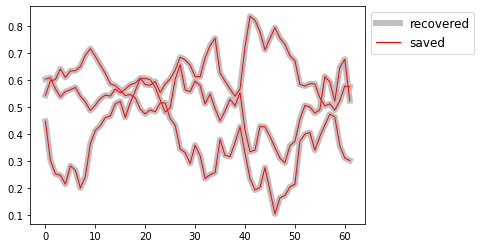

In [46]:
h1 = plt.plot(H_recover.T, color='silver', lw=6)
h2 = plt.plot(ssNMF_results['H'][r_idx][run_idx_sel].T, color='r', lw=1)
plt.legend([h1[0], h2[0]], ['recovered', 'saved'], fontsize=12, bbox_to_anchor=(1,1))
plt.show()

From the above we know that we can exactly recover this run.

### Re-run ssNMF using the random seed

Let's see if we can re-run ssNMF can get the same output when using the same initial condition and early-stopping parameters.

In [47]:
# Get data
pkl_data_path = '../ooi_sonar/nmf_paper_analysis_notebooks/parallel_ops/nyu_hpc/par_setup_files'
with open(os.path.join(pkl_data_path, 'low_rank_MVBS_data.pkl'), 'rb') as ff:
        data = dill.load(ff)

In [48]:
model = ssnmf.smoothNMF(n_components=3, 
                        max_iter=2000, 
                        smoothness=500000, 
                        sparsity=0, 
                        early_stopping={'type': 'cost'}
                       )
model.fit(data, init='random', random_state=1190)

Stopping at iteration 702


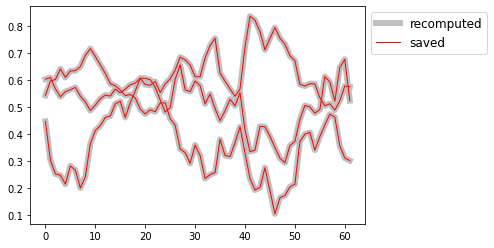

In [49]:
h1 = plt.plot(model.H.T, color='silver', lw=6)
h2 = plt.plot(ssNMF_results['H'][r_idx][run_idx_sel].T, color='r', lw=1)
plt.legend([h1[0], h2[0]], ['recomputed', 'saved'], fontsize=12, bbox_to_anchor=(1,1))
plt.show()

We have verified that this initial random seed does lead to exactly the same results.

### Test plotting Ws

In [50]:
# dB-diff results of daily echogram patterns
Ws_reshaped_dBdiff = np.zeros(Ws_reshaped.shape)
Ws_reshaped_mean = np.zeros(Ws_reshaped.shape)
Ws_freq0 = np.zeros(Ws_reshaped.shape)
for icomp in range(Ws_reshaped.shape[0]):
    Ws_ref = Ws_reshaped[icomp, :n_depth_levels, :]
    Ws_reshaped_dBdiff[icomp,:,:] = Ws_reshaped[icomp,:,:] - np.array([Ws_ref]*3).reshape(-1,n_pings)
    Ws_freq0[icomp,:,:] = np.array([(Ws_ref-Ws_ref.min())/(Ws_ref.max()-Ws_ref.min())]*3).reshape(-1,n_pings)
    Ws_freq_mean = Ws_reshaped[icomp, :, :].reshape(n_frequencies, n_depth_levels, n_pings).mean(axis=0)
    Ws_freq_mean = (Ws_freq_mean-Ws_freq_mean.min())/(Ws_freq_mean.max()-Ws_freq_mean.min())
    Ws_reshaped_mean[icomp,:,:] = np.array([Ws_freq_mean]*3).reshape(-1,n_pings)  # used for setting alpha later

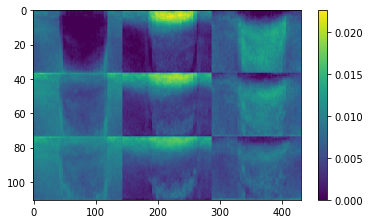

In [51]:
# 3 components (left to right) at all frequencies (top to bottom)
plt.figure(figsize=(6,3.5))
plt.imshow(np.hstack(Ws_reshaped),aspect='auto')
_ = plt.colorbar()

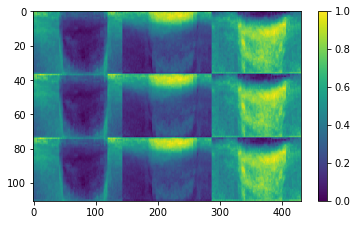

In [52]:
# Mean across all 3 frequencies, used for setting alpha in db-diff plots
plt.figure(figsize=(6,3.5))
plt.imshow(np.hstack(Ws_reshaped_mean),aspect='auto')
_ = plt.colorbar()

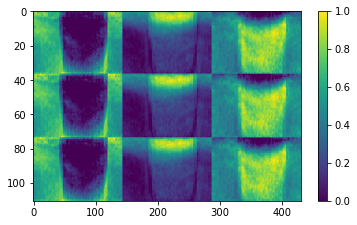

In [53]:
# Sanity check: 3 components (left to right) at the first frequency
plt.figure(figsize=(6,3.5))
plt.imshow(np.hstack(Ws_freq0),aspect='auto')
_ = plt.colorbar()

In [54]:
vmax = Ws_reshaped_dBdiff.max()
vmin = -vmax

In [55]:
from matplotlib.colors import Normalize

In [56]:
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
cmap = plt.cm.coolwarm
colors = Normalize(vmin, vmax, clip=True)(Ws_reshaped_dBdiff)
colors = cmap(colors)
colors[..., -1] = Ws_reshaped_mean  # set the alpha channel to the one we created above

In [57]:
def inspect_components(bkg_val):
    bkg = np.full((*Ws_reshaped.shape, 3), bkg_val, dtype=np.uint8)

    fig,ax = plt.subplots(1,3,figsize=(16,3))

    im = ax[0].imshow(np.hstack(Ws_reshaped), aspect='auto')
    plt.colorbar(im, ax=ax[0])
    ax[0].set_title('Components, normalized')

    im = ax[1].imshow(np.hstack(Ws_reshaped_dBdiff), cmap='coolwarm', aspect='auto')
    plt.colorbar(im, ax=ax[1])
    ax[1].set_title('Components, dB-diff, no mask')

    ax[2].imshow(np.hstack(bkg))
    im = ax[2].imshow(np.hstack(colors), cmap='coolwarm', aspect='auto', vmax=vmax, vmin=vmin)
    plt.colorbar(im, ax=ax[2])
    ax[2].set_title('Components, dB-diff, strength mask')

    plt.show()

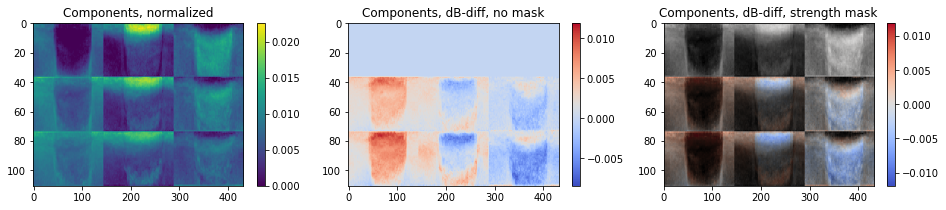

In [58]:
inspect_components(0)

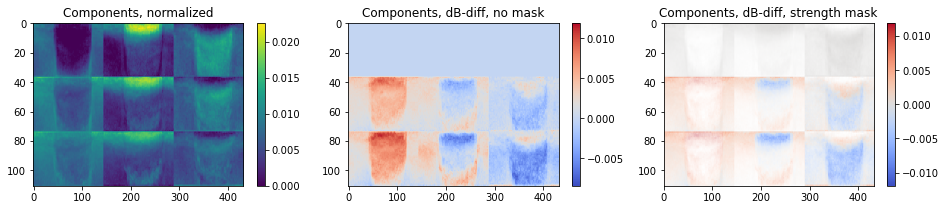

In [59]:
inspect_components(255)

## FIGURE 4.

In [60]:
# Assemble dataset for activation
ds_activation = xr.Dataset(
    {
        'H': (['day', 'component'], Hs_reshaped)
    },
    coords={
        'component': np.arange(3),
        'day': MVBS_rpca['low_rank'].date.values
    }
)

In [61]:
panel_ls=12
title_ls=10
freq_ls=8
comp_ls=8
axis_ls=8
legend_ls=6
tick_ls=8
pad_size=1

In [62]:
cmap = plt.cm.get_cmap('YlGnBu')

# Set custom color cycle
from cycler import cycler
# mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')  # default mpl color cycle
# plt.rcParams['axes.prop_cycle'] = cycler(color='cmbgryk')
plt.rcParams['axes.prop_cycle'] = cycler(color=cmap([0.3,0.6,1.0]))

In [63]:
def set_ax_ticks(ax):
    """Plot the tick marks for component panels
    """
    ax.set_xticks([])
    ax.set_yticks(np.arange(0,n_depth_levels*3,n_depth_levels)-1)
    ax.set_yticklabels('')
    ax.grid()
#     ax.grid(alpha=0.5)

In [64]:
def plot_daily_echogram_colorbar(im, ax1, ax2):
    pos_ax_left = ax1.get_position()
    pos_ax_right = ax2.get_position()
    cax = fig.add_axes([pos_ax_right.x0+pos_ax_right.width+0.015, 
                            pos_ax_left.y0, 
                            0.015, 
                            pos_ax_right.height])
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_ticks(np.arange(0,0.035,0.01))
    cbar.ax.tick_params(labelsize=tick_ls, pad=pad_size)
    return cbar

In [65]:
def plot_daily_echogram():
    vmin, vmax = Ws_reshaped.min(), Ws_reshaped.max()  # common colorbar for all components
    ax_pattern = []
    for seq in range(3):  # loop through 3 components
        ax_pattern.append(fig.add_subplot(gs_L[0,seq]))
        im = ax_pattern[-1].imshow(Ws_reshaped[seq,:,:], aspect='auto',
                                   vmax=vmax, vmin=vmin, cmap='magma')
        set_ax_ticks(ax_pattern[-1])
    plot_daily_echogram_colorbar(im, ax_pattern[0], ax_pattern[2])
    return ax_pattern

In [66]:
def plot_activation():
    ax_activation = fig.add_subplot(gs_R[0])
    h1 = ds_activation.H.plot.line(x='day', ax=ax_activation,
                                   add_legend=False, _labels=False)
    ax_activation.xaxis.set_major_locator(
        mdates.MonthLocator(bymonth=range(8,11), bymonthday=[1,15]))
    ax_activation.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    ax_activation.xaxis.set_minor_locator(mdates.AutoDateLocator())
    ax_activation.set_xlim([datetime.date(2015,8,16), datetime.date(2015,10,18)])
#     ax_activation.set_ylim(0, 2700)
    ax_activation.set_title('')
    ax_activation.tick_params(labelsize=tick_ls, pad=pad_size)
    return ax_activation

In [67]:
def plot_daily_echogram_pattern_scale():
    gs_ex = fig.add_gridspec(1,1, bottom=0.48, top=0.58, left=0.278, right=0.342)
    ax_ex = fig.add_subplot(gs_ex[0,0])
    ax_ex.set_xticks([])
    ax_ex.set_yticks([])
    ax_ex.set_facecolor(np.ones(3)*0.6)

    trans = ax_ex.get_xaxis_transform()
    ax_ex.plot([0,1],[-0.2,-0.2],  # add a line for horizontal scale
                color='k', lw=2.5, 
                transform=trans, clip_on=False)
    ax_ex.annotate('24 hr',             # annotate
                    xy=(0.1,-0.8), xycoords=trans, 
                    ha='left', va='bottom', 
                    fontsize=axis_ls)
    trans = ax_ex.get_yaxis_transform()
    ax_ex.plot([1.15,1.15],[0.2,1],  # add a line for vertical scale
                color='k', lw=2.5, 
                transform=trans, clip_on=False)
    ax_ex.annotate('200 m',            # annotate
                    xy=(1.7,0.7), xycoords=trans, 
                    ha='center', va='top', rotation=0,
                    fontsize=axis_ls)
    fig.text(x=-0.55, y=0.5, s='Scale:', 
             transform=ax_ex.transAxes,
             fontsize=title_ls, 
             rotation=0, ha='center', va='center')

In [68]:
def add_panel_A_label():
    fig.text(x=-1.3,y=1.1,s='A',
             transform=ax_pattern[0].transAxes,
             fontsize=panel_ls, fontweight='bold')
    fig.text(x=0.5,y=1.25,s='Echogram patterns',
             transform=ax_pattern[1].transAxes,
             fontsize=title_ls, ha='center')
    fig.text(x=-0.8, y=-0, s='Frequency (kHz)', 
             transform=ax_pattern[0].transAxes,
             fontsize=title_ls, 
             rotation=90, ha='center', va='bottom')

In [69]:
def add_panel_B_label():
    fig.text(x=-0.1,y=1.1,s='B',
             transform=ax_activation.transAxes,
             fontsize=panel_ls, fontweight='bold')
    fig.text(x=0.5,y=1.1,s='Activation',
             transform=ax_activation.transAxes,
             fontsize=title_ls, ha='center')
    fig.text(x=-0.16, y=-0.05, s='Relative strength', 
             transform=ax_activation.transAxes,
             fontsize=title_ls, 
             rotation=90, ha='center', va='bottom')

In [70]:
import datetime

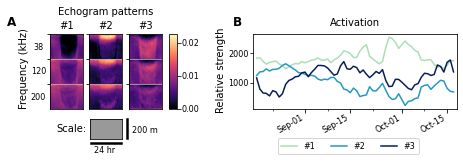

In [71]:
fig = plt.figure(figsize=(7+1/16,2.8))
gs_L = fig.add_gridspec(2,3, bottom=0.2, top=1.0, left=0.2,  right=0.42, hspace=0.15)
gs_R = fig.add_gridspec(2,1, bottom=0.2, top=1.0, left=0.6, right=1, hspace=0.15)

# Panel: daily echogram patterns
ax_pattern = plot_daily_echogram()

# Panel: Activation
ax_activation = plot_activation()

# Add echogram pattern labels
[ax_pattern[x-1].set_title('#%d' % x, fontsize=title_ls, pad=5) for x in np.arange(1,4,1)]

# Add component legend
ax_activation.legend(['#1', '#2', '#3'], 
                  fontsize=tick_ls,
                  bbox_to_anchor=(0.1, -0.65), 
                  loc='lower left', ncol=3)

# Add panel label
add_panel_A_label()
add_panel_B_label()

# Add frequency for echogram patterns
[fig.text(
        x=-0.35, y=yy, s=ss, transform=ax_pattern[0].transAxes,
        fontsize=freq_ls,
        ha='center', va='center')
    for ss,yy in zip(['200', '120', '38'], [0.15, 0.5, 0.825])]

# Add example axis for daily echogram patterns
plot_daily_echogram_pattern_scale()

# Save figure
fig.savefig(os.path.join('./figs/','fig_results_decomp.png'),
            dpi=150, bbox_inches = 'tight', pad_inches = 0.05)
plt.show()